In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import RSLPStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv('/kaggle/input/instagram-reach/instagram_reach.csv')

In [3]:
df.head()

,Unnamed: 0,S.No,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,0,1,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,11 hours,139
1,1,2,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,2 hours,23
2,2,3,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,255,#whoiswho #aitrading #ai #aitradingteam#instat...,2 hours,25
3,3,4,opensourcedworkplace,sfad,340,#iot #cre#workplace #CDO #bigdata #technology#...,3 hours,49
4,4,5,crea.vision,Ever missed a call while your phone was chargi...,304,#instamachinelearning #instabigdata#instamarke...,3 hours,30


In [4]:
df.isna().sum()

Unnamed: 0           0
S.No                 0
USERNAME             0
Caption              6
Followers            0
Hashtags             0
Time since posted    0
Likes                0
dtype: int64

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.drop(["Unnamed: 0", "S.No"], axis=1,inplace=True)

<AxesSubplot: xlabel='Followers', ylabel='Density'>

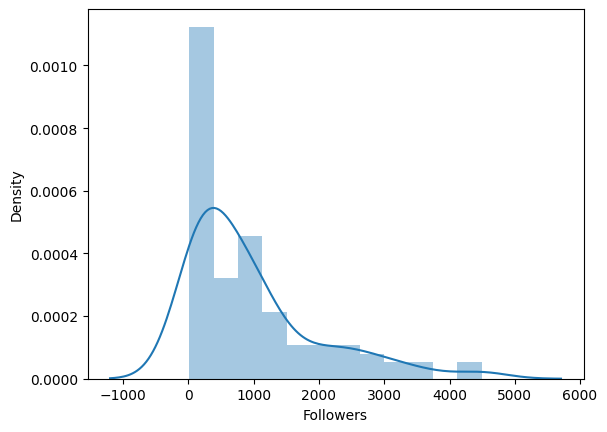

In [7]:
sns.distplot(df['Followers'])


<AxesSubplot: xlabel='Likes', ylabel='Density'>

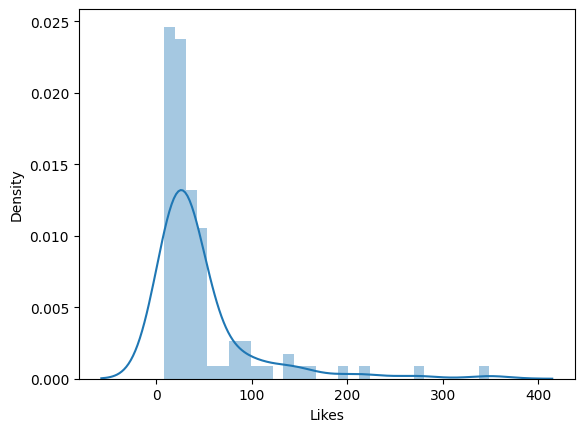

In [8]:
sns.distplot(df['Likes'])

<AxesSubplot: xlabel='Followers', ylabel='Likes'>

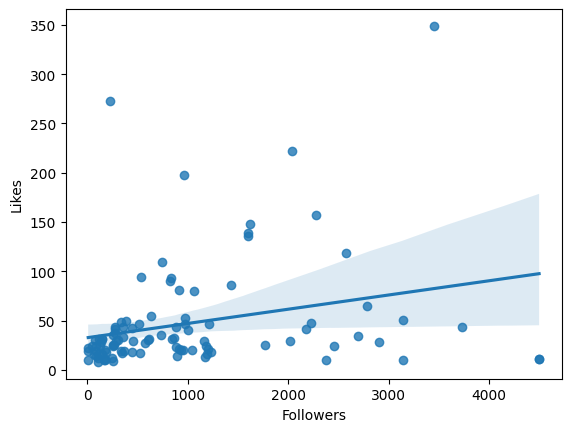

In [9]:
sns.regplot(x=df['Followers'],y=df['Likes'])

In [10]:
df['Time since posted']=df['Time since posted'].str.split().str[0]
df['Time since posted']=df['Time since posted'].astype('int64')

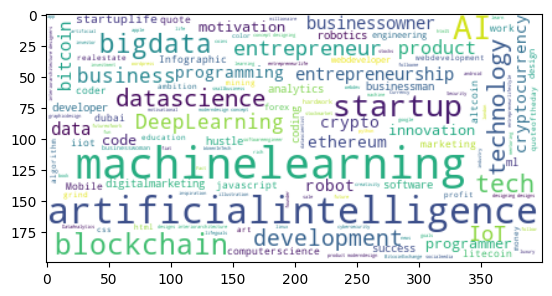

In [ ]:
text = " ".join(i for i in df.Hashtags)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')

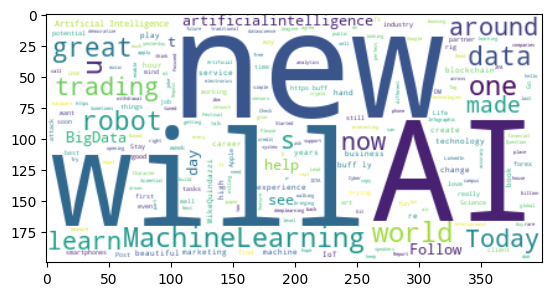

In [5]:
df['Caption'].fillna(" ",inplace=True)
text = " ".join(i for i in df['Caption'].tolist())
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')

In [13]:
import nltk
from nltk.corpus import stopwords
vectorizer=CountVectorizer()
nltk.download('stopwords')
stop=stopwords.words('english')
pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
stemmer=RSLPStemmer()  
def text_processing(sentences):
    processed=[]
    for sen in sentences:
        sen=str(sen)
        sen=re.sub('[\n\r]',' ',sen)
        sen=re.sub(pattern,'link',sen)
        sen=re.sub('\W', ' ', sen)
        sen=re.sub('\s+', ' ', sen)
        sen=re.sub('[ \t]+$', '', sen)
        sen=" ".join([word.lower() for word in sen.split() if word.lower() not in stop])
        sen=' '.join([stemmer.stem(word) for word in sen.split()])
        processed.append(sen)
    return processed

caption = text_processing(df['Caption'].tolist())
hashtags=text_processing(df['Hashtags'].tolist())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names_out()
    
    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features
    
tfidf_vectorizer = TfidfVectorizer(max_features=400,  max_df=0.8, stop_words='english')

# Extracting features for the corpus
countv_features, df_caption_features =extract_features_from_corpus(caption, tfidf_vectorizer, df=True)
countv_features, df_hashtags_features =extract_features_from_corpus(hashtags, tfidf_vectorizer, df=True)
d=pd.concat([df_caption_features,df_hashtags_features,df['Followers']],axis=1)

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

def run_models(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame):
    
    models = [          
          ('Random Forest', RandomForestRegressor(random_state=2020)),
          ('Decision Tree', DecisionTreeRegressor()),                                                 
          ('SVM', SVR()),
        ('LR',LinearRegression()),
        ]  
    
    for name, model in models:        
        # unscaled data
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        MSE=mse(y_test,model.predict(X_test))
        print(f'RMSE of {name} : {MSE} ') 
run_models(xtrain,ytrain,xtest,ytest)

RMSE of Random Forest : 1332.1100700000002 
RMSE of Decision Tree : 3050.5 
RMSE of SVM : 1869.5850380876 
RMSE of LR : 1135.417783436197 
